<a href="https://colab.research.google.com/github/Abdelrhman2022/IMDB-Sentiment-Analysis/blob/main/IMDB_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/kaggle_dataset'

In [3]:
%cd /content/drive/MyDrive/kaggle_dataset

/content/drive/MyDrive/kaggle_dataset


In [4]:
!ls

kaggle.json


# <center> IMDB Sentiment Analysis

### Model Used:
- LSTM
- BERT
- Linear SVC

The data consists of 50000 comments. There are 25000 negative and 25000 positive comments. Comments are of different lengths and are given in sentences.
Using the imdb dataset, we will train our LSTM model with positive and negative comments about movies. First, we will make comments available for the LSTM model. After training our model, we will examine the accuracy and loss values on the chart.


## Install Libraries

In [5]:
!pip install pandarallel
!pip install -q kaggle
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pandarallel: filename=pandarallel-1.6.1-py3-none-any.whl size=16265 sha256=c36f25277c1302bee2c4d8d523c5a269d79c6b57d9a52c48acd288184fb35cd6
  Stored in directory: /root/.cache/pip/wheels/e8/81/8f/29aafd7d671a4e9db4e976d71728870173f0b3f48ccba0bc32
Successfully built pandarallel
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 30.8 MB/s 
     |████████████████████████████████| 596 kB 69.5 MB/s 
     |████████████████████████████████| 101 kB 13.4 MB/s 
     |████████████████████████████████| 6.6 MB 60.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [6]:
!mkdir ~/.kaggle

!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

Download IMDB Dataset From Kaggle

In [7]:
!kaggle datasets download lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
!unzip imdb-dataset-of-50k-movie-reviews.zip

 35% 9.00M/25.7M [00:00<00:01, 13.2MB/s]
100% 25.7M/25.7M [00:00<00:00, 33.6MB/s]
Archive:  imdb-dataset-of-50k-movie-reviews.zip
  inflating: IMDB Dataset.csv        


## Import Libraries

In [9]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy import stats

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Embedding,LSTM
from keras.layers import Dropout
from sklearn.model_selection import train_test_split
from bs4 import BeautifulSoup
import re
import nltk 
nltk.download("stopwords")
from nltk.corpus import stopwords
nltk.download('punkt')

import warnings
warnings.filterwarnings("ignore")

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 1 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [10]:
df = pd.read_csv("IMDB Dataset.csv")

In [11]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [12]:
# we are looking at the size of our data.
df.shape

(50000, 2)

## Exploratory Data Analysis

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


- we see that there is no null value in our data. 

In [14]:
# statistical summary of our data
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


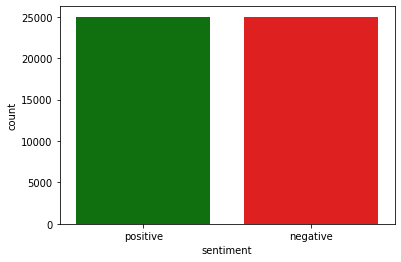

positive    25000
negative    25000
Name: sentiment, dtype: int64


In [15]:
sns.countplot(df["sentiment"], palette = ["green","red"])
plt.show()
print(df.sentiment.value_counts())

<ul>
    <li  style = "color:green" > <p style = "color:black;font-weight:bold" > We see that the number of positive and negative comments is equal. </p> </li>
</ul>

In [16]:
class_names = {"positive":1, "negative":0}
inv_class_names = {v: k for k, v in class_names.items()}

df.sentiment = df.sentiment.map(class_names)

 We convert our sentiment property to int values. 
 - positive --> 1 
 - negative --> 0 


In [17]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


### Generating word frequencies

Let's first generate a frequency table of all the words present in all the reviews combined.

In [18]:
def gen_freq(text):
    # store all words in list
    words_list = []
    
    # Loop over all the words and extract word from list
    for word in text.split():
        words_list.extend(word)
        
    # Generate word frequencies using value counts in word_list
    word_freq = pd.Series(words_list).value_counts()
        
    return word_freq    

## Create Word clouds
### Word cloud using word frequencies

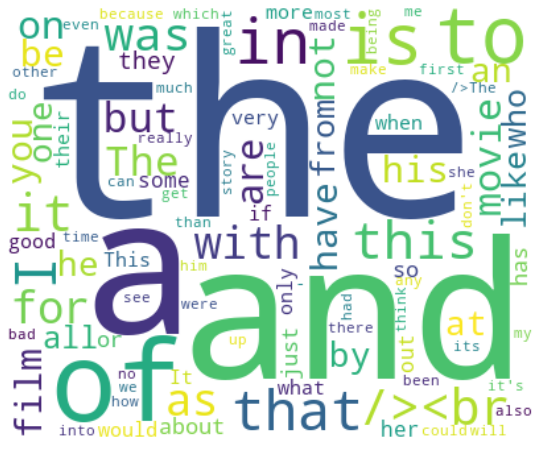

In [19]:
#Import library WordCloud
from wordcloud import WordCloud

# Generate word cloud
wc = WordCloud(width=400, 
               height=330, 
               max_words=100, 
               background_color='white').generate_from_frequencies(gen_freq(df.review.str))

plt.figure(figsize=(14,8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

### Word cloud for positive reviews

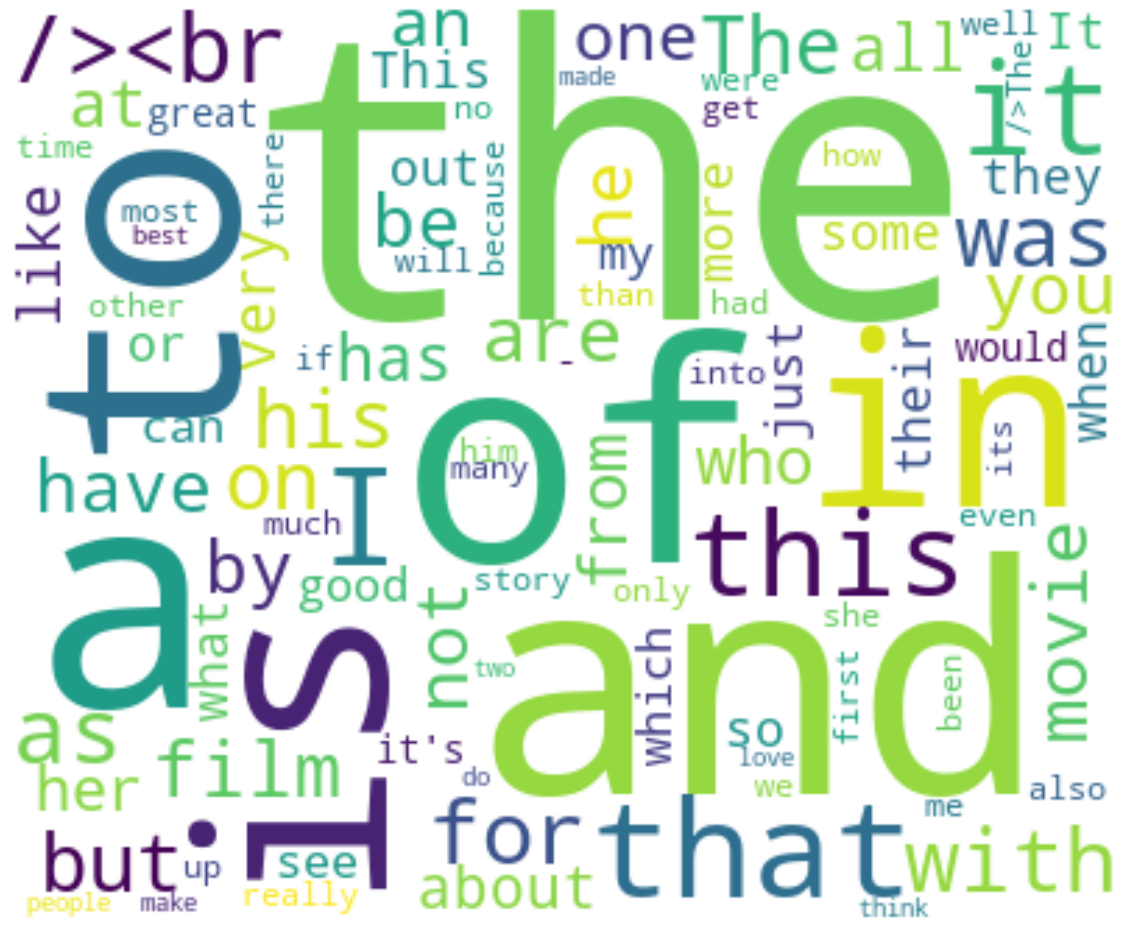

In [20]:
plt.figure(figsize = (20,20))
wc = WordCloud(width=400, 
               height=330, 
               max_words=100, 
               background_color='white').generate_from_frequencies(gen_freq(df[df.sentiment == 1].review.str))

plt.axis("off")
plt.imshow(wc , interpolation = 'bilinear')

### Word cloud for negative reviews

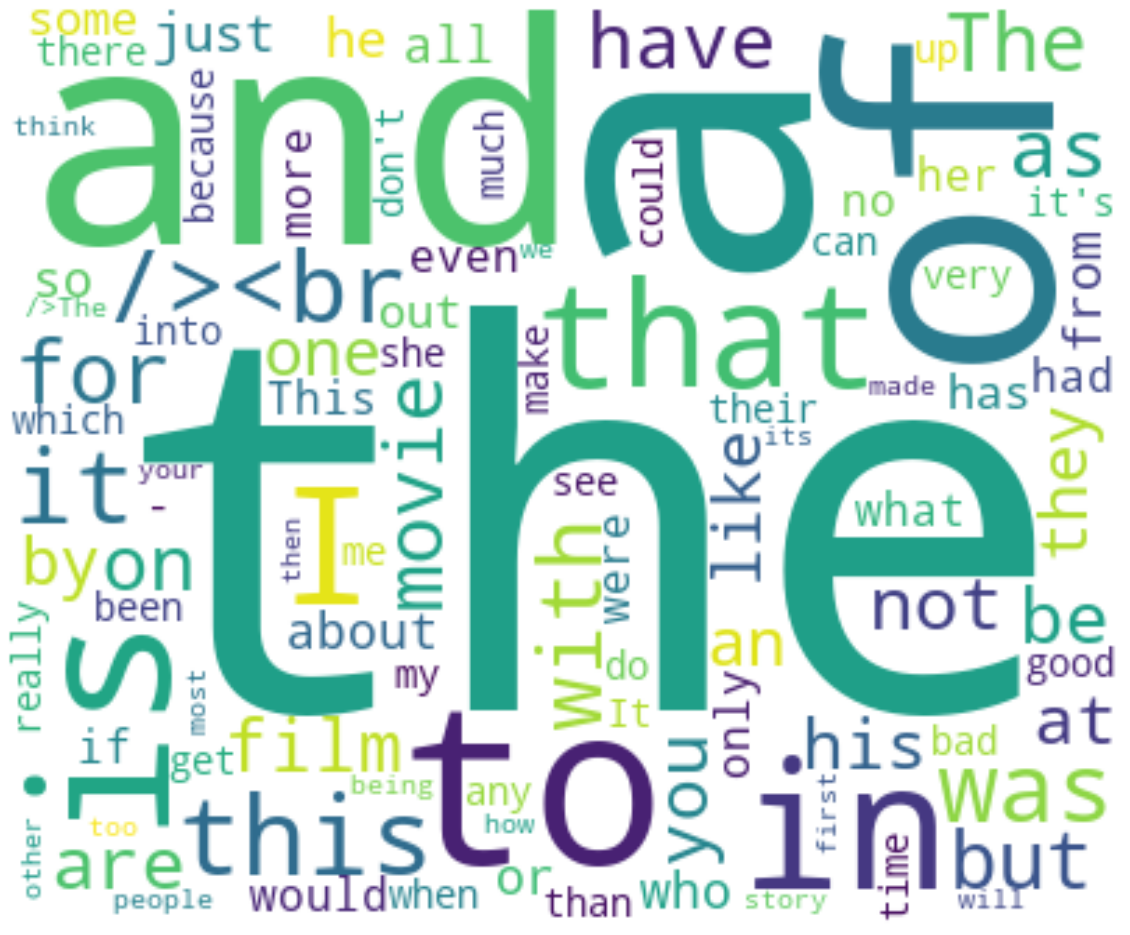

In [21]:
plt.figure(figsize = (20,20))
wc = WordCloud(width=400, 
               height=330, 
               max_words=100, 
               background_color='white').generate_from_frequencies(gen_freq(df[df.sentiment == 0].review.str))

plt.axis("off")
plt.imshow(wc , interpolation = 'bilinear')

### Removing Stopwords

In [22]:
from nltk.corpus import stopwords
stop_word_list = stopwords.words('english')

In [23]:
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.tokenize.toktok import ToktokTokenizer

In [24]:
# Tokenization of text
tokenizer = ToktokTokenizer()

In [25]:
# removing stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stop_word_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stop_word_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

# Apply function on review column
df['review'] = df['review'].parallel_apply(remove_stopwords)

## Text Cleaning

- process of clearing punctuation marks in data
- cleaning unnecessary marks in data. </p> </li>
- capitalization to lowercase. </p> </li>
- cleaning extra spaces. </p> </li>
- removal of stopwords in sentences. </p> </li>


In [26]:
# clearing punctuation & unnecessary marks
df['review'] = df['review'].parallel_apply(lambda x: re.sub('[,\.!?:()"]', '', x))
df['review'] = df['review'].parallel_apply(lambda x: re.sub('[^a-zA-Z"]', ' ', x))

# capitalization to lowercase
df['review'] = df['review'].parallel_apply(lambda x: x.lower())

# cleaning extra spaces
df['review'] = df['review'].parallel_apply(lambda x: re.sub(' +', ' ', x).strip())

### Removing html strips and noise text


In [27]:
# Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

# Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

def remove_tags(text):
    TAG_RE = re.compile(r'<[^>]+>')
    return TAG_RE.sub('', text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text

df['review'] = df['review'].parallel_apply(denoise_text)

df['review'].head()

0    one reviewers mentioned watching oz episode ho...
1    wonderful little production br br the filming ...
2    thought wonderful way spend time hot summer we...
3    basically family little boy jake thinks zombie...
4    petter mattei love time money visually stunnin...
Name: review, dtype: object

## Generating Word clouds after text cleaning :

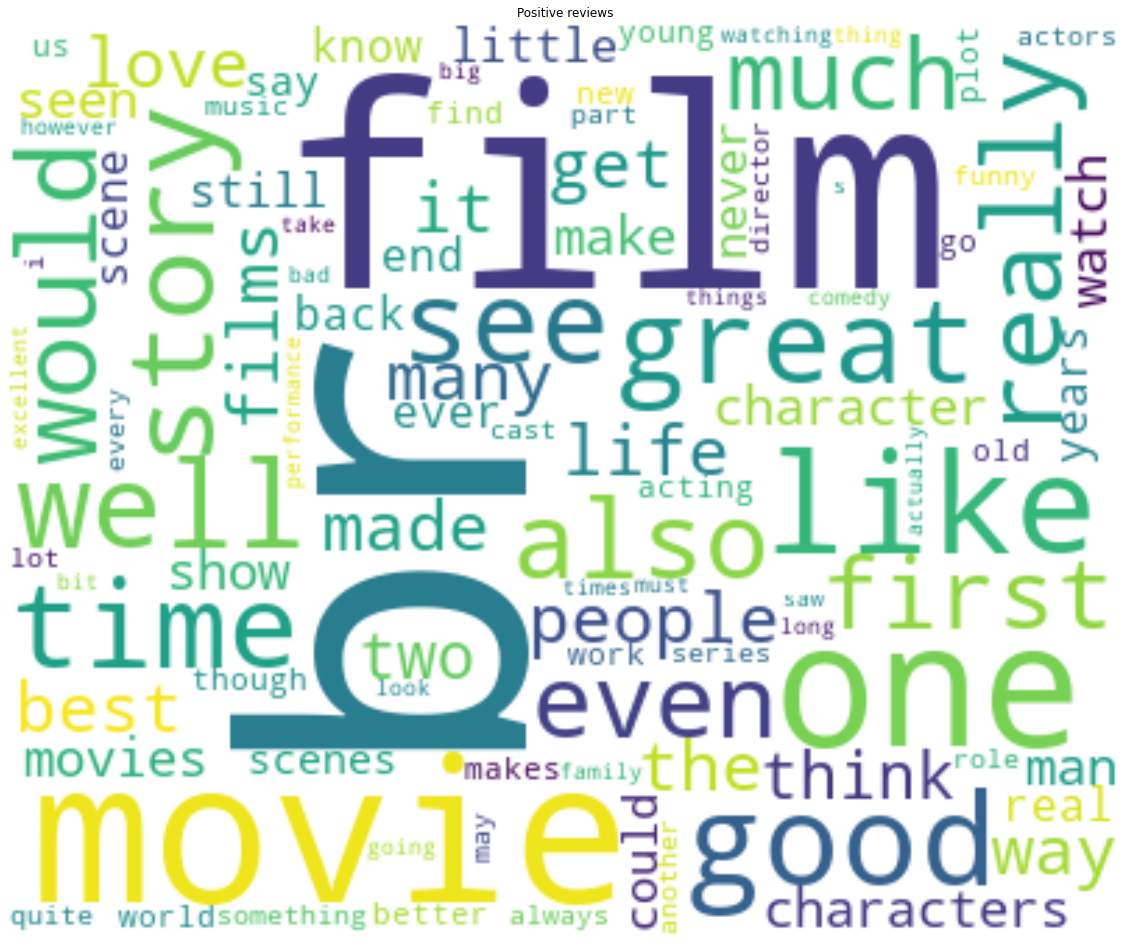

In [28]:
# POSITIVE REVIEWS
plt.figure(figsize = (20,20))
wc = WordCloud(width=400, 
               height=330, 
               max_words=100, 
               background_color='white').generate_from_frequencies(gen_freq(df[df.sentiment == 1].review.str))

plt.axis("off")
plt.title('Positive reviews')
plt.imshow(wc , interpolation = 'bilinear')

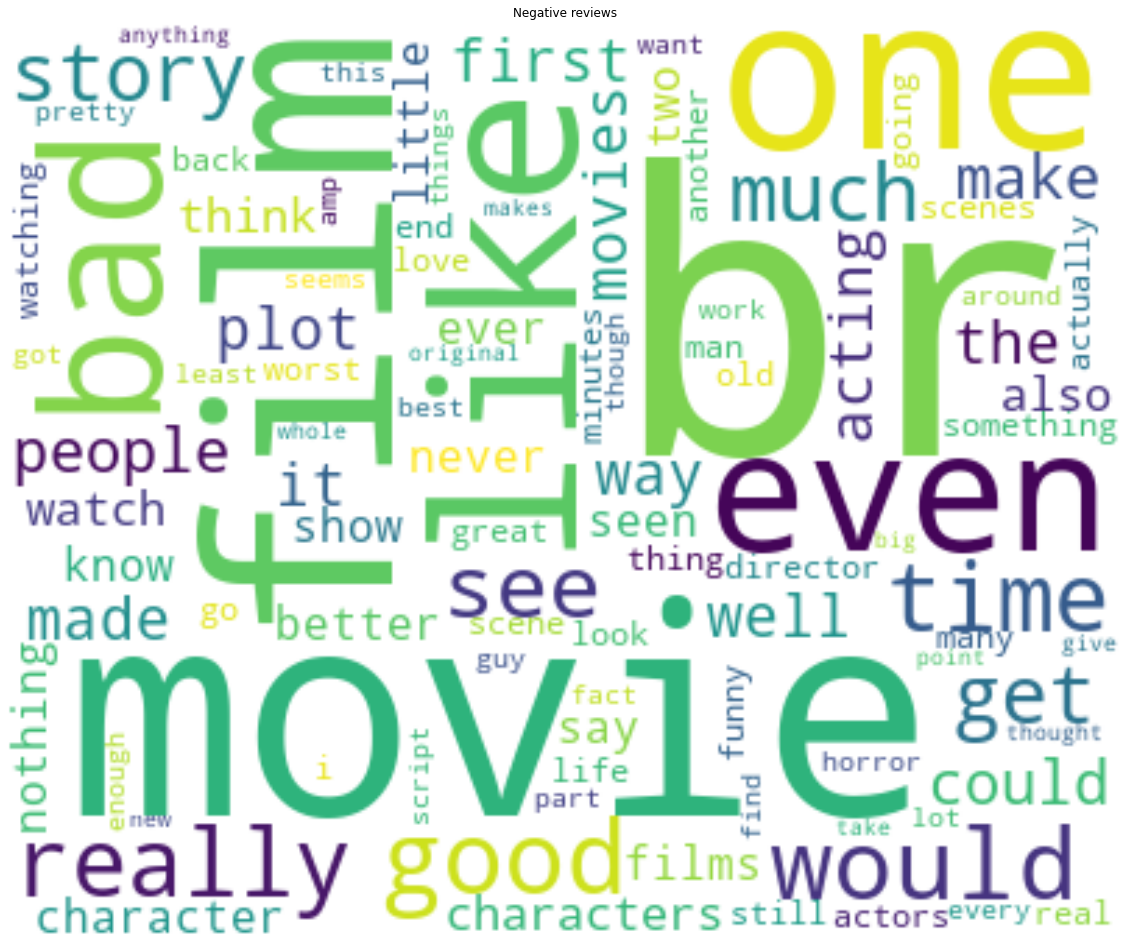

In [29]:
# Negative Reviews
plt.figure(figsize = (20,20))
wc = WordCloud(width=400, 
               height=330, 
               max_words=100, 
               background_color='white').generate_from_frequencies(gen_freq(df[df.sentiment == 0].review.str))

plt.axis("off")
plt.title('Negative reviews')
plt.imshow(wc , interpolation = 'bilinear')

## Train - Test Split 

In [30]:
sentiments = df['sentiment'].values
reviews = df['review']

In [31]:
reviews[:5]

0    one reviewers mentioned watching oz episode ho...
1    wonderful little production br br the filming ...
2    thought wonderful way spend time hot summer we...
3    basically family little boy jake thinks zombie...
4    petter mattei love time money visually stunnin...
Name: review, dtype: object

In [32]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(reviews,
                                                    sentiments,
                                                    test_size = 0.2, 
                                                    random_state = 42)

### Creating a Dictionary 
We create a dictionary of 15000 most used words in English for later use. 

In [33]:
from tensorflow.keras.preprocessing.text import Tokenizer

max_words = 15000
tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(reviews)

#### Bring the comments to the same size
comments of different lengths cannot train the model. That's why we need to make the sentences the same size. 

In [34]:
x_train_tokens = tokenizer.texts_to_sequences(x_train)
x_test_tokens = tokenizer.texts_to_sequences(x_test)

- We can replace the words in our sentences with whichever index they are included in the dictionary we have created above. 

In [35]:
# Then we take the word count of each of our sentences in our data and create a list.
num_tokens = [len(tokens) for tokens in x_train_tokens + x_test_tokens]
num_tokens = np.array(num_tokens)

In [36]:
# Here, when setting the number of tokens, a number is determined by taking into account the variability around the average.
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_tokens = int(max_tokens)
max_tokens

292

 max_tokens : This value will allow us to reduce the distribution of sentences in our data and the sentences with opposite lengths, if any, to the average. 

In [37]:
#It is checked what percentage of the data this determined number covers.
np.sum(num_tokens < max_tokens) / len(num_tokens)

0.9454

In [38]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

#data is adjusted according to the number of tokens specified
x_train_pad = pad_sequences(x_train_tokens, maxlen=max_tokens)
x_test_pad = pad_sequences(x_test_tokens, maxlen=max_tokens)

In [39]:
x_train_pad.shape

(40000, 292)

In [40]:
idx = tokenizer.word_index
inverse_map = dict(zip(idx.values(), idx.keys()))

def return_to_sentence(tokens):
    words = [inverse_map[token] for token in tokens if token!=0]
    text = ' '.join(words)
    return text

- We write a function to revert the sentences that we have made int.


In [41]:
#normal comment
print(return_to_sentence(x_train_pad[9]))

thesis behind rise evil seems br br hitler bad man bad man hated jews case miss going fact every scene film br br there effort whatsoever try explain mood time hitler may adopted views strategy did needless say unlike generally excellent nazis warning history film neglected point fact nearly leaders munich communist rising jewish may views subject linking jews absolutely crucial aspect understanding much nazi era br br but much understanding done film makers going go got stuff knew anyway certainly get fascinating fact hitler briefly socialist communist immediately ww would course far complex film handle might even detract relentless bad away incessantly br br we know bad man however also know figure public speaker private situations could polite even sympathetic course views like anti alcohol anti smoking many guardian readers could agree with also famously fond animals hence wholly invented dog scene absurd br br he also accounts seen brave soldier ww whilst saw iron cross never get 

In [42]:
#token equivalent of comment
print(x_train_pad[9])

[13039   403  2074   352    88     1     1  2064    15    46    15    46
  1695  4385   303   586    73    96    76    49     3     1     1   271
   671  1516   244  1146  1136     7  2064   101  5224  2694 10670  1296
  3034    51   923  1187   210  3462  1635   369     3  6946   119    96
   692  6040 12722  4158  4186  2302   101  2694   685 14522  4385   306
  4159  1183  1656    14  2418   883     1     1   555    14  1656   120
     3  1115    73    54    93   406   569   441   310    16  1324    96
  2064  3101 11031  4158  1111  4883     9   158   123  1190     3  2718
   130     8  6436  6547    15   138 14934     1     1  2197    43    15
    46    95    19    43   729   937  9834  1856  1031    25  9357     8
  2091   158  2694     5   975  4630   975  3056    34  7503  6075    25
   913   876    19 14028  4150  1474  2818  5298  5109   675    49  1762
     1     1  2289    19  5945    35  2681  1424  4883  1710   111  3887
  1506    37    16    12  1292  9531   126  3034   

##  LSTM Model 

In [43]:
def build_lstm_model():
    model = Sequential()

    embedding_size = 50

    model.add(Embedding(input_dim=max_words,output_dim=embedding_size,input_length=max_tokens,name='embedding_layer'))

    model.add(LSTM(units=16, return_sequences=True))
    model.add(Dropout(0.1))

    model.add(LSTM(units=8, return_sequences=True))
    model.add(Dropout(0.1))

    model.add(LSTM(units=4))
    model.add(Dropout(0.1))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

    return model

In [44]:
model = build_lstm_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_layer (Embedding)  (None, 292, 50)           750000    
_________________________________________________________________
lstm (LSTM)                  (None, 292, 16)           4288      
_________________________________________________________________
module_wrapper (ModuleWrappe (None, 292, 16)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 292, 8)            800       
_________________________________________________________________
module_wrapper_1 (ModuleWrap (None, 292, 8)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 4)                 208       
_________________________________________________________________
module_wrapper_2 (ModuleWrap (None, 4)                 0

In [45]:
history = model.fit(x_train_pad, 
                    y_train, 
                    validation_split=0.2, 
                    epochs=10, 
                    batch_size=500,
                    shuffle=True, 
                    verbose = 1)

Epoch 1/10
64/64 [==============================] - 98s 1s/step - loss: 0.6222 - accuracy: 0.7080 - val_loss: 0.4773 - val_accuracy: 0.8396
Epoch 2/10
64/64 [==============================] - 91s 1s/step - loss: 0.3925 - accuracy: 0.8862 - val_loss: 0.3728 - val_accuracy: 0.8717
Epoch 3/10
64/64 [==============================] - 89s 1s/step - loss: 0.2851 - accuracy: 0.9236 - val_loss: 0.3365 - val_accuracy: 0.8742
Epoch 4/10
64/64 [==============================] - 90s 1s/step - loss: 0.2283 - accuracy: 0.9399 - val_loss: 0.3386 - val_accuracy: 0.8739
Epoch 5/10
64/64 [==============================] - 89s 1s/step - loss: 0.1930 - accuracy: 0.9509 - val_loss: 0.3506 - val_accuracy: 0.8695
Epoch 6/10
64/64 [==============================] - 91s 1s/step - loss: 0.1690 - accuracy: 0.9590 - val_loss: 0.3616 - val_accuracy: 0.8708
Epoch 7/10
64/64 [==============================] - 89s 1s/step - loss: 0.1506 - accuracy: 0.9655 - val_loss: 0.3819 - val_accuracy: 0.8700
Epoch 8/10
64/64 [==

### Evaluation 

In [46]:
test_accuracy = model.evaluate(x_test_pad, y_test)[1] * 100

print("Accuracy of the model on Testing Data is: {:.2f}%".format(test_accuracy))

313/313 [==============================] - 77s 244ms/step - loss: 0.4319 - accuracy: 0.8688
Accuracy of the model on Testing Data is: 86.88%


##  Visualization of Accuracy & Loss

In [47]:
preds = model.predict(x_test_pad)
preds = np.round(preds).astype(int)
preds[:5]

array([[0],
       [1],
       [0],
       [1],
       [0]])

In [48]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score

target_names = ['Positive Reviews','Negative Reviews']

print(classification_report(y_test, preds, target_names = target_names))

                  precision    recall  f1-score   support

Positive Reviews       0.87      0.86      0.87      4961
Negative Reviews       0.86      0.88      0.87      5039

        accuracy                           0.87     10000
       macro avg       0.87      0.87      0.87     10000
    weighted avg       0.87      0.87      0.87     10000



Text(69.0, 0.5, 'Actual')

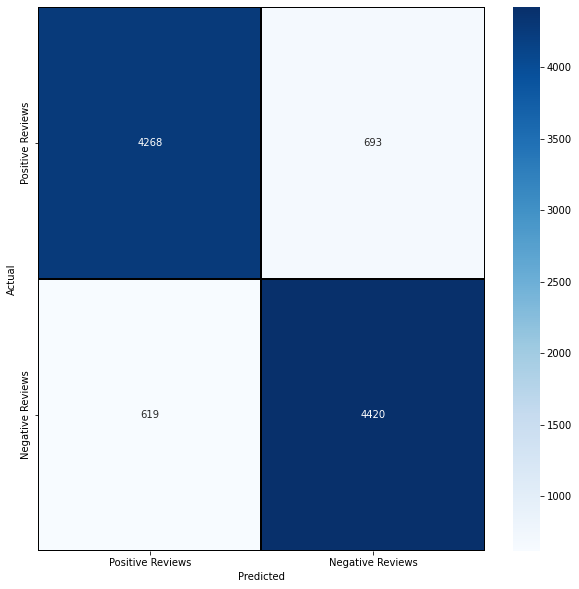

In [49]:
cm = confusion_matrix(y_test, preds)

plt.figure(figsize = (10,10))
sns.heatmap(cm, 
            cmap= "Blues", 
            linecolor = 'black' , 
            linewidth = 1 , 
            annot = True, 
            fmt='' , 
            xticklabels = target_names , 
            yticklabels = target_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")

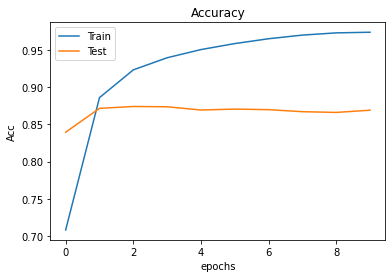

In [50]:
plt.figure()
plt.plot(history.history["accuracy"], label = "Train")
plt.plot(history.history["val_accuracy"], label = "Test")
plt.title("Accuracy")
plt.ylabel("Acc")
plt.xlabel("epochs")
plt.legend()
plt.show()

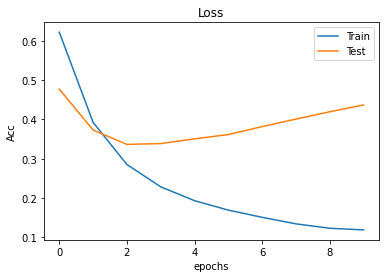

In [51]:
plt.figure()
plt.plot(history.history["loss"], label = "Train")
plt.plot(history.history["val_loss"], label = "Test")
plt.title("Loss")
plt.ylabel("Acc")
plt.xlabel("epochs")
plt.legend()
plt.show()

### Save Model as H5 File

In [52]:
model_path = "imdb_lstm_classifier"
model.save(model_path)

INFO:tensorflow:Assets written to: imdb_lstm_classifier/assets


INFO:tensorflow:Assets written to: imdb_lstm_classifier/assets


### Save Tokenizer as Pickle File

In [53]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Load Inference Model and Tokenizer For Prediction


In [54]:
import tensorflow as tf
import pickle

inv_class_names = {0: 'negative', 1: 'positive'}

# loading tokenizer
with open('tokenizer.pickle', 'rb') as handle:
    loaded_tokenizer = pickle.load(handle)

# loading classifer
inference_model = tf.keras.models.load_model(model_path)
inference_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_layer (Embedding)  (None, 292, 50)          750000    
                                                                 
 lstm (LSTM)                 (None, 292, 16)           4288      
                                                                 
 module_wrapper (ModuleWrapp  (None, 292, 16)          0         
 er)                                                             
                                                                 
 lstm_1 (LSTM)               (None, 292, 8)            800       
                                                                 
 module_wrapper_1 (ModuleWra  (None, 292, 8)           0         
 pper)                                                           
                                                                 
 lstm_2 (LSTM)               (None, 4)                 2

In [56]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def predict_sentiment(input_text, loaded_tokenizer, inference_model, inv_class_names):
    input_text_tokens = loaded_tokenizer.texts_to_sequences([input_text])
    input_text_pad = pad_sequences(input_text_tokens, maxlen=max_tokens)
    input_pred = inference_model.predict(input_text_pad)
    pred_class_index = np.round(input_pred[0][0]).astype(int)
    pred_class = inv_class_names[pred_class_index]
    return pred_class



# Write your own review
# input_text = "this was a terrible film with too much violence i walked out halfway through"
# input_text = "this is the best film i have ever seen it is great and fantastic and i loved it"
input_text = "this was an awful film that i will never see again"
# input_text = "it is a very good film i will it see again"

pred_class = predict_sentiment(input_text,loaded_tokenizer, inference_model, inv_class_names)
print("Review: " + input_text)
print("Predicted Class: " + pred_class)

Review: this was an awful film that i will never see again
Predicted Class: negative


## Linear SVC

In [57]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

In [58]:
text_clf = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', LinearSVC()),])

In [59]:
text_clf.fit(x_train, y_train)


Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', LinearSVC())])

In [60]:
from sklearn.metrics import accuracy_score

predictions = text_clf.predict(x_train)
accuracy_train = accuracy_score(y_train, predictions)
print('Train Accuracy:',accuracy_train)

Train Accuracy: 0.988425


In [61]:
predictions = text_clf.predict(x_test)
accuracy_test = accuracy_score(y_test, predictions)
print('Test Accuracy:',accuracy_test)

Test Accuracy: 0.8952


Save SVC Classifier to disk


In [62]:
filename = 'imdb_svc_classifier.pkl'
pickle.dump(text_clf, open(filename, 'wb'))

### SVC Model Inference

In [63]:
import pickle

inv_class_names = {0: 'negative', 1: 'positive'}

# Load SVC Classifier from disk
filename = 'imdb_svc_classifier.pkl'
svc_model = pickle.load(open(filename, 'rb'))

In [64]:
# input_text = "this was a terrible film with too much violence i walked out halfway through"
input_text = "this is the best film i have ever seen it is great and fantastic and i loved it"
# input_text = "this was an awful film that i will never see again"
# input_text = "it is a very good film i will it see again"

def predict_sentiment(input_text, svc_model, inv_class_names):
    return inv_class_names[svc_model.predict([input_text])[0]]

pred_class = predict_sentiment(input_text, svc_model, inv_class_names)
print("Predicted Class: ", pred_class)

Predicted Class:  positive
